# **'Where's Wally' with Machine Learning: Pytorch Version**

### Imports

In [ ]:
# Standard libraries
import os
from PIL import Image
import time

# Torch & torchvision related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets import CocoDetection
from torchvision.transforms import transforms
import torchvision.transforms.functional as F
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Matplotlib, numpy and visualisation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Third-party API
!pip install roboflow
from roboflow import Roboflow

!pip install pycocotools
from engine import train_one_epoch, evaluate

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using:", device)

Using: cpu


### Load in API dataset

In [ ]:
# https://universe.roboflow.com/tan-rmi/whereiswaldo-ssmol/dataset/3
rf = Roboflow(api_key="iE53lBCUXtDffBO8i7dk")
project = rf.workspace("tan-rmi").project("whereiswaldo-ssmol")
version = project.version(3)
dataset = version.download("coco")
print(dataset.location)

loading Roboflow workspace...
loading Roboflow project...
/content/WhereIsWaldo-3


### Transform data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  [0.229, 0.224, 0.225]),
])

### Custom preprocessing

In [ ]:
class PreprocessedCocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super().__init__(root, annFile)
        self.transform = transform

    # Establish an index for images and ground truth label
    def __getitem__(self, index):
        image, target = super().__getitem__(index)

        # PIL returns (w, h) of an image as a tuple
        original_width, original_height = image.size

        # Reduce image size by 10%
        scale_factor = 0.9
        width = int(original_width * scale_factor)
        height = int(original_height * scale_factor)

        # Scale down the images with resize LANCZOS is good for high quality images
        image = image.resize((width, height), Image.LANCZOS)

        # Reduce colors to 32 and convert from palette mode to 3 channel RGB
        image = image.quantize(colors=256).convert("RGB")

        # Scale the bounding boxes similarly to the images so proportions are correct using scale factor ratios
        for obj in target:
            x, y, w, h = obj["bbox"]
            x = int(x * scale_factor)
            y = int(y * scale_factor)
            w = max(1, int(w * scale_factor))
            h = max(1, int(h * scale_factor))

            x1 = x
            y1 = y
            x2 = x + w
            y2 = y + h
            # print(f"Scaled bbox: {[x1, y1, x2, y2]}")

            # Convert bounding boxes to tensor here cause you can't with transform
            # obj["bbox"] = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)
            # obj["bbox"] = torch.tensor([x, y, w, h], dtype=torch.float32)
            obj["bbox"] = [x, y, w, h]

        # Apply transformations!
        if self.transform:
            image = self.transform(image)

        target = convert_target_to_tensor(target)

        return image, target

### Converting target fully into a tensor

In [ ]:
def convert_target_to_tensor(target):
    bboxes = []
    labels = []
    image_ids = []
    areas = []

    # Loop through each object in the target list and extract bounding boxes and category_ids
    for obj in target:

        bbox = obj["bbox"]
        category_id = obj["category_id"]
        image_id = obj["image_id"]
        area = obj["area"]

        bboxes.append(bbox)
        labels.append(category_id)
        image_ids.append(image_id)
        areas.append(area)

    # Convert list of bounding boxes and category_ids into tensors
    bboxes_tensor = torch.tensor(bboxes)  # Stack bounding boxes
    labels_tensor = torch.tensor(labels)

    return {
        "boxes": bboxes_tensor,
        "labels": labels_tensor,
        "image_id": image_id,
        "areas": areas
    }

### Data is loaded in and preprocessed

In [ ]:
dataset_path = "/content/WhereIsWaldo-3"
train_images = os.path.join(dataset_path, "train")
train_annotations = os.path.join(dataset_path, "train", "_annotations.coco.json")

val_images = os.path.join(dataset_path, "valid")
val_annotations = os.path.join(dataset_path, "valid", "_annotations.coco.json")

test_images = os.path.join(dataset_path, "test")
test_annotations = os.path.join(dataset_path, "test", "_annotations.coco.json")

# print(train_dataset[0][0].shape, train_dataset[0][1].shape)

train_dataset = PreprocessedCocoDataset(root=train_images, annFile=train_annotations, transform=transform)
val_dataset = PreprocessedCocoDataset(root=val_images, annFile=val_annotations, transform=transform)
test_dataset = PreprocessedCocoDataset(root=test_images, annFile=test_annotations, transform=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

# print(train_dataset[0])
# print('-' * 60)
# print(f"Train samples: {len(train_dataset)} Shape: {train_dataset[0][0].shape}")
# print('-' * 60)
# print(f"Validation samples: {len(val_dataset)} Shape: {val_dataset[0][0].shape}")
# print('-' * 60)
# print(f"Test samples: {len(test_dataset)} Shape: {test_dataset[0][0].shape}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# images, targets = next(iter(train_loader))

# print("Type of targets:", type(targets))          # should be list
# print("Type of targets[0]:", type(targets[0]))    # should be dict
# print("Keys in target[0]:", targets[0].keys())

# # Check shapes
# print("Boxes shape:", targets[0]['boxes'].shape)  # should be [N, 4]
# print("Labels shape:", targets[0]['labels'].shape)  # should be [N]


### Random testing section

In [ ]:
# image, target = convert_target_to_tensor(train_dataset[0][1])
# print(target.shape)

In [ ]:
# image, target = train_dataset[0]
# print(image.shape)
# print(target[0]["bbox"].shape)

In [ ]:
# # Convert target into tensors (bounding boxes and labels)
# bboxes_tensor, labels_tensor = convert_target_to_tensor(target)

# print(bboxes_tensor.shape)  # Shape of the bounding boxes tensor
# print(labels_tensor.shape)  # Shape of the labels tensor

#### Visual example with ground truth bounding box

[ 7 34 10  8]


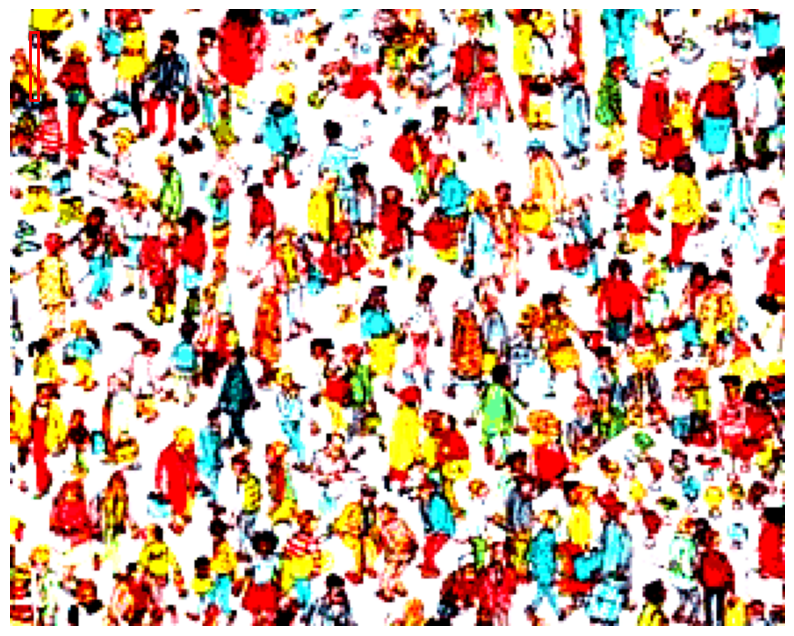

In [ ]:
def show_sample(dataset, index=0):
    image, target = dataset[index]

    image = image.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    # image = (image * 255).astype(np.uint8)  # Bring it back to 0-255 range

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Draw bounding boxes
    boxes = target["boxes"].cpu().numpy()
    for box in boxes:
        x1, y1, x2, y2 = box
        print(box)
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

show_sample(train_dataset, index=98)

<!-- IoU: 0.0023265595227248428
Decent proposal found!
IoU: 0.015077989820484911
Decent proposal found!
IoU: 0.02583111349354341
Decent proposal found!
IoU: 0.06015002843666607
Decent proposal found!
IoU: 0.09366832535885171
Decent proposal found!
IoU: 0.0870719644180875
Decent proposal found!
IoU: 0.0612090046899427
Decent proposal found!
IoU: 0.05384125412541256
Decent proposal found!
IoU: 0.030910547368421065
Decent proposal found!
IoU: 0.02508973000683528
Decent proposal found!
IoU: 0.008175449480663897
Decent proposal found!
IoU: 0.021347063099738304
Decent proposal found!
IoU: 0.01110418735646649
...
IoU: 0.002757796769346357
Decent proposal found!
IoU: 0.0019187744420594555
Decent proposal found!
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings... -->

### Adjust model for labels

In [ ]:
# # Load a pretrained Faster R-CNN trained on COCO with a ResNet50 backbone and Feature Pyramid Network (FPN)
# model = fasterrcnn_resnet50_fpn(weights="DEFAULT", progress=True)

# # Grabs the number of input features that the current classifuer expects (1024)
# input_features = model.roi_heads.box_predictor.cls_score.in_features

# # Replace the classification layer to match 2 classses 1. wally 2. background
# model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes=2)
# model.eval()

### Training Faster R-CNN with ResNet50

#### Define Optimiser and LR Scheduler

In [ ]:
# params = [p for p in model.parameters() if p.requires_grad]
# optimiser = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.1)

#### Training loop

In [ ]:
# model.to(device)

# num_epochs = 20

# for epoch in range(num_epochs):
#     start_time = time.time()

#     train_one_epoch(model, optimiser, train_loader, device, epoch, print_freq=110)
#     lr_scheduler.step()
#     evaluate(model, test_loader, device=device)

#     end_time = time.time()
#     elapsed = end_time - start_time

#     print(f"Epoch {epoch + 1}/{num_epochs} finished in {elapsed:.2f} seconds.")


In [ ]:
# torch.save(model.state_dict(), '/content/fasterrcnn_resnet50_wally_original.pth')

#### Save the weight

In [ ]:
model = fasterrcnn_resnet50_fpn(weights=None)
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes=2)
model.load_state_dict(torch.load("/content/fasterrcnn_resnet50_wally.pth", map_location=torch.device('cpu')))
model.eval()
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# model.load_state_dict(torch.load("fasterrcnn_resnet50_wally.pth"))


### Visualise a random test sample

In [ ]:
def visualise_prediction(image, prediction, score_threshold):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for box, score in zip(prediction[0]["boxes"], prediction[0]["scores"]):
        if score > score_threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(x1, y1, f"Score: {score:.2f}", color='white', fontsize=12,
                    bbox=dict(facecolor='green', alpha=0.5))

    plt.axis("off")
    plt.show()

In [ ]:
def show_random_prediction(model, dataset, device, score_threshold=0.5):
    model.eval()

    image, _ = dataset[np.random.randint(len(dataset))]

    with torch.no_grad():
        prediction = model([image.to(device)])

    visualise_prediction(image, prediction, score_threshold)

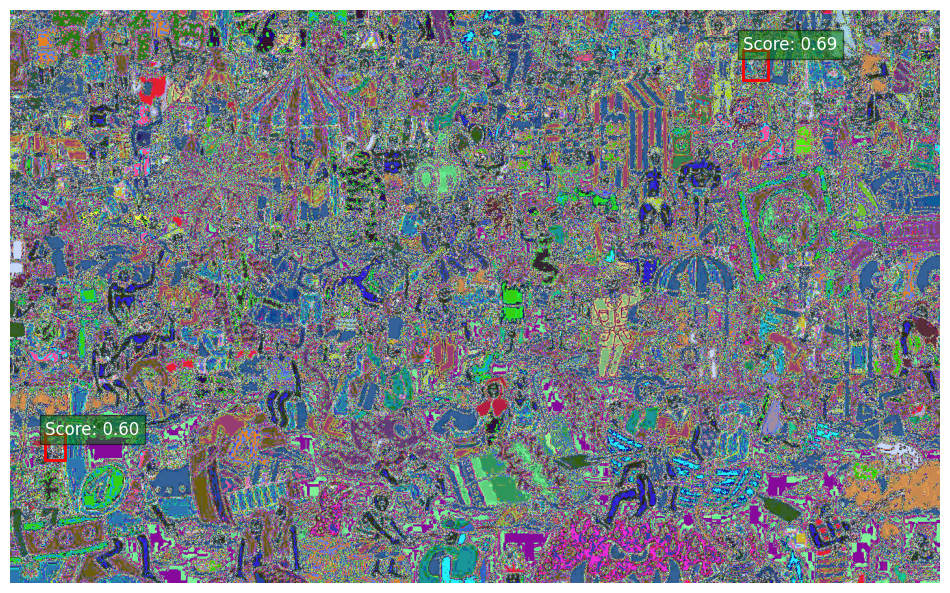

In [ ]:
show_random_prediction(model, test_dataset, device, score_threshold=0.5)

In [ ]:
def extract_coco_metrics(evaluator):
    stats = evaluator.coco_eval['bbox'].stats

    metrics = {
        "AP@[IoU=0.50:0.95]": stats[0],
        "AP@[IoU=0.50]": stats[1],
        "AP@[IoU=0.75]": stats[2],
        "AP@[small]": stats[3],
        "AP@[medium]": stats[4],
        "AP@[large]": stats[5],
        "AR@[maxDets=1]": stats[6],
        "AR@[maxDets=10]": stats[7],
        "AR@[maxDets=100]": stats[8],
        "AR@[small]": stats[9],
        "AR@[medium]": stats[10],
        "AR@[large]": stats[11],
    }

    print("\n===== COCO Evaluation Metrics =====")
    for k, v in metrics.items():
        if v >= 0:
            print(f"{k:<25}: {v:.3f}")
        else:
            print(f"{k:<25}: N/A")

    return metrics


In [ ]:
image, target = test_dataset[0]
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])

print("TARGET:", target)
print("PREDICTION:", prediction)


TARGET: {'boxes': tensor([[408, 279,  32,  35]]), 'labels': tensor([1]), 'image_id': 0, 'areas': [1404]}
PREDICTION: [{'boxes': tensor([[410.2667, 280.1426, 436.3376, 309.3414],
        [270.0804, 413.9313, 280.7320, 428.5019],
        [159.1042,  10.6108, 185.7207,  49.1849],
        [177.7539, 323.2917, 188.8106, 336.2492],
        [182.6681, 362.4784, 210.8548, 391.7403],
        [193.3802,   7.4077, 208.4569,  30.8537],
        [415.3784, 491.3322, 431.2488, 508.5272],
        [335.8575, 426.9151, 347.3919, 436.3808],
        [175.1477, 319.3069, 187.5500, 340.7083],
        [334.7192, 200.5576, 359.1727, 228.3459],
        [ 48.8526, 456.5034,  73.6272, 500.5831],
        [ 96.2322, 182.6902, 110.9075, 198.9148],
        [415.9849, 348.9305, 447.0000, 430.0881],
        [381.4340, 496.0520, 404.4855, 518.6021],
        [ 70.4680, 270.6530,  89.0739, 289.0756],
        [404.2815, 417.0267, 428.1151, 449.9360],
        [285.4326, 177.9601, 306.6002, 202.0285],
        [371.7132, 484

In [ ]:
image, target = test_dataset[0]

print("Sample target keys:", target.keys())
print("Boxes:", target["boxes"])              # Should be Tensor in x1,y1,x2,y2
print("Labels:", target["labels"])            # Tensor
print("Image ID:", target["image_id"])


Sample target keys: dict_keys(['boxes', 'labels', 'image_id', 'areas'])
Boxes: tensor([[367, 251,  28,  31]])
Labels: tensor([1])
Image ID: 0


In [ ]:
result = evaluate(model, test_loader, device=device)
metrics = extract_coco_metrics(result)

Test:  [ 0/21]  eta: 0:10:24  model_time: 26.2045 (26.2045)  evaluator_time: 0.0155 (0.0155)  time: 29.7237  data: 3.5034
Test:  [20/21]  eta: 0:00:22  model_time: 21.0283 (22.2701)  evaluator_time: 0.0040 (0.0051)  time: 22.0869  data: 0.0041
Test: Total time: 0:07:51 (22.4536 s / it)
Averaged stats: model_time: 21.0283 (22.2701)  evaluator_time: 0.0040 (0.0051)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Aver